<a href="https://colab.research.google.com/github/vasudhamanikandan/SYS6016/blob/main/SYS_6016_Project_Custom_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

! pip install -q tensorflowjs
import tensorflowjs as tfjs

np.random.seed(49) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(49)

     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 112kB 14.4MB/s 


In [ ]:
# Convert pretrained model to TF.js format
loaded_model = tf.keras.models.load_model("drive/MyDrive/currencyModel/0001")
# tfjs_target_dir = "drive/MyDrive/currencyModelJS"
# tfjs.converters.save_keras_model(loaded_model, tfjs_target_dir)

In [ ]:
! pip install -q kaggle

from google.colab import files

In [ ]:
if not os.path.exists('kaggle.json'):
  # Upload kaggle.json file downloaded from Kaggle account
  files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
if not os.path.exists('/root/.kaggle'):
  ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
if not os.path.exists('Indian currency dataset v1'):
  ! kaggle datasets download vishalmane109/indian-currency-note-images-dataset-2020
  ! unzip -q indian-currency-note-images-dataset-2020.zip

100% 2.31G/2.31G [00:30<00:00, 39.0MB/s]
100% 2.31G/2.31G [00:30<00:00, 81.2MB/s]


In [ ]:
# Add class folder structure to test folder

# Check if one of the desired folders exists to prevent FileExistsError
if not os.path.exists('./Indian currency dataset v1/test/10/'):
  test_files = os.listdir('./Indian currency dataset v1/test')
  test_classes = [(name.replace('.', '').replace('_', '__').split('__'))[0] for name in test_files]

  test_tups = list(zip(test_classes, test_files))

  test_dict = {}
  for tup in test_tups:
    key = tup[0]
    val = tup[1]
    if tup[0] in test_dict:
      test_dict[key].append(val)
    else:
      test_dict[key] = [val]

  for key in test_dict.keys():
    test_dir = './Indian currency dataset v1/test'
    os.mkdir(f'{test_dir}/{key}')
    for file_name in test_dict[key]:
      os.rename(f'{test_dir}/{file_name}', f'{test_dir}/{key}/{file_name}')

In [ ]:
train_dir = "/content/Indian currency dataset v1/training/"
val_dir = "/content/Indian currency dataset v1/validation/"
test_dir = "/content/Indian currency dataset v1/test/"

batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 112; 
img_width = 112;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed = 49,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed = 49,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Test Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed = 49,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3566 files belonging to 8 classes.
Found 345 files belonging to 8 classes.
Found 91 files belonging to 8 classes.


In [ ]:
train_ds.class_names

['10', '100', '20', '200', '2000', '50', '500', 'Background']

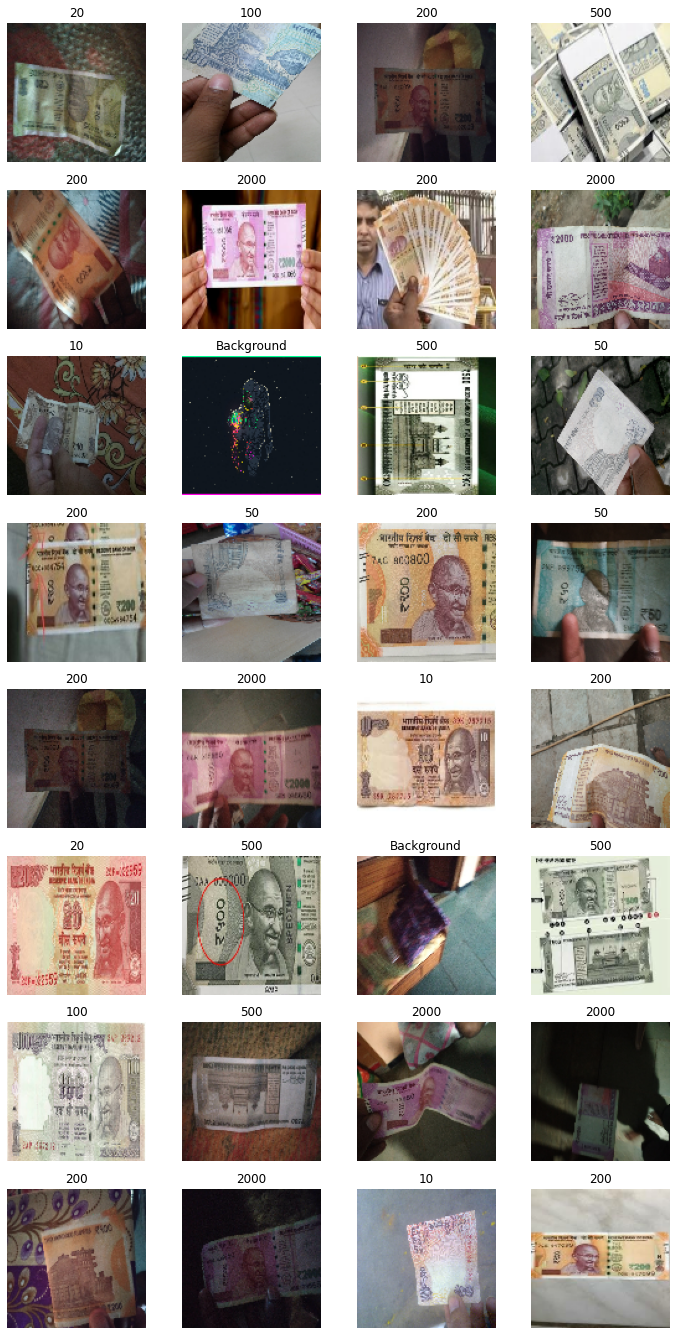

In [ ]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = train_ds.class_names

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [ ]:
n_classes = len(train_ds.class_names)

def plot_epochs(history_list):
  table = pd.concat(pd.DataFrame(l) for l in history_list).reset_index()

  fig, ax1 = plt.subplots()
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(table['loss'], color='red')

  ax2 = ax1.twinx()
  ax2.set_ylabel('val_loss')
  ax2.plot(table['val_loss'])

  plt.grid(True)

## Model 0 (smaller images)

In [ ]:
model_0 = keras.Sequential([
                            keras.layers.Conv2D(filters=16, kernel_size=6, padding="same",
                                                input_shape=[img_height, img_width, 3]),
                            keras.layers.MaxPool2D(2),
                            keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
                            keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
                            keras.layers.MaxPool2D(2),
                            keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
                            keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
                            keras.layers.MaxPool2D(2),
                            keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
                            keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
                            keras.layers.MaxPool2D(2),
                            
                            ## Output layers
                            keras.layers.Flatten(),
                            keras.layers.Dense(n_classes, activation="softmax")
                            ])

model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      1744      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        3

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model_0.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Storing model performance data
model_history_0 = []

In [ ]:
history = model_0.fit(train_ds, validation_data=validation_ds, epochs=12)
model_history_0.append(history.history)

Epoch 1/12
112/112 [==============================] - 113s 690ms/step - loss: 6.0854 - accuracy: 0.1843 - val_loss: 1.6017 - val_accuracy: 0.3768
Epoch 2/12
112/112 [==============================] - 83s 694ms/step - loss: 1.4695 - accuracy: 0.4629 - val_loss: 1.1038 - val_accuracy: 0.6174
Epoch 3/12
112/112 [==============================] - 83s 699ms/step - loss: 1.1495 - accuracy: 0.5969 - val_loss: 0.9102 - val_accuracy: 0.6841
Epoch 4/12
112/112 [==============================] - 83s 697ms/step - loss: 0.8585 - accuracy: 0.7079 - val_loss: 0.8930 - val_accuracy: 0.6928
Epoch 5/12
112/112 [==============================] - 84s 705ms/step - loss: 0.6861 - accuracy: 0.7648 - val_loss: 0.9743 - val_accuracy: 0.6957
Epoch 6/12
112/112 [==============================] - 84s 704ms/step - loss: 0.5818 - accuracy: 0.8068 - val_loss: 0.9294 - val_accuracy: 0.6986
Epoch 7/12
112/112 [==============================] - 83s 700ms/step - loss: 0.4526 - accuracy: 0.8544 - val_loss: 0.9776 - val_a

KeyboardInterrupt: ignored

In [ ]:
model_0.evaluate(test_ds)

3/3 [==============================] - 2s 124ms/step - loss: 0.2004 - accuracy: 0.9451


[0.2003689408302307, 0.9450549483299255]

In [ ]:
model_name = "currencyModelSmall"
model_version = "0001"
saved_model_path = os.path.join(model_name, model_version)
model_0.save(saved_model_path)

INFO:tensorflow:Assets written to: currencyModelSmall/0001/assets
